In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

## Load the data

In [2]:
df = pd.read_csv('../cleaned_data/TLKM.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,-1.257411,-1.265240,-1.272727,-0.808345,0.491269,0.706085,0.927517,0.696955,1.053230,1.012777,0.0,0.5,0.5,-1.0,0.594005,0.066667,0.592593,-1.248980
2012-10-18,-1.253889,-1.260517,-1.269972,-0.830223,-0.014190,0.278954,0.557617,0.054518,0.628572,0.633022,0.5,0.5,0.5,-1.0,0.599455,0.133333,0.592593,-1.265306
2012-10-19,-1.253889,-1.258155,-1.268005,-0.830223,-0.014190,0.278954,0.557617,0.319828,0.968469,0.918278,1.0,0.5,0.5,-1.0,0.604905,0.200000,0.592593,-1.265306
2012-10-22,-1.253889,-1.255203,-1.266037,-0.830223,-0.491719,-0.129789,0.200645,-0.324491,0.591624,0.640169,-1.0,0.5,0.5,-1.0,0.621253,0.400000,0.629630,-1.281633
2012-10-23,-1.258585,-1.254613,-1.264856,-0.760737,0.022975,0.231437,0.483864,-0.324491,0.429086,0.803149,-0.5,0.5,0.5,-1.0,0.626703,0.466667,0.629630,-1.265306


### Plot the Close price - our target

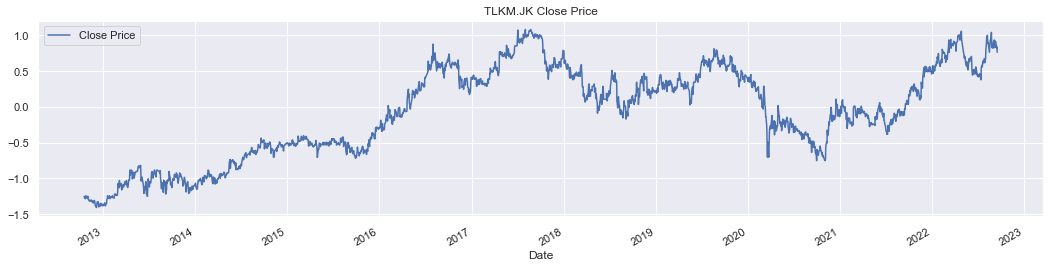

In [3]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('TLKM.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [4]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [6]:
import statsmodels.api as sm

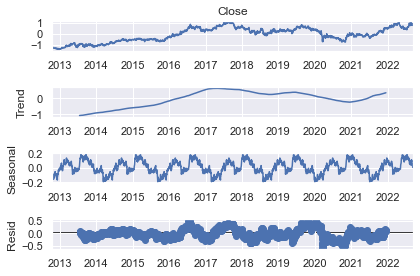

In [7]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [9]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence for Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Close Price


In [10]:
"""
The Close price is not stationary. 
Therefore, differencing needs to be performed
"""
test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price - First Difference


### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


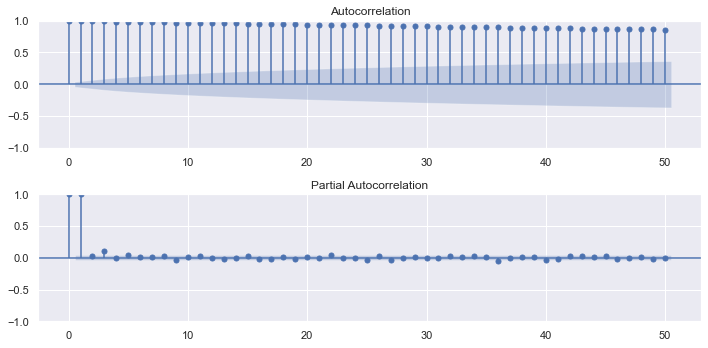

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.tight_layout()
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [12]:
from pmdarima.arima import auto_arima

In [13]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=1, start_q=1, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=5.40 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=-3713.924, Time=0.39 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-5726.288, Time=1.16 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=-5003.017, Time=1.32 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=-3715.083, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-5291.625, Time=0.84 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-5926.059, Time=2.28 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=-3776.111, Time=1.11 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-5934.627, Time=3.54 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=-5746.368, Time=1.70 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=4.56 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=-5935.1

In [14]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, [1], 5)   Log Likelihood                3165.543
Date:                             Wed, 23 Nov 2022   AIC                          -6313.087
Time:                                     20:35:58   BIC                          -6262.851
Sample:                                          0   HQIC                         -6294.623
                                            - 1967                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.118e-05   6.23e-05      0.822      0.411   -7.09e-05       0.000
ar.L1          0.8908      0.016     54.357      0.000       0.859       0.923
ar.L2          0.0702      0.024      2.868      0.004       0.022       0.118
ar.L3         -0.0502      0.024     -2.080      0.038      -0.097      -0.003
ar.L4          0.0666      0.017      3.918      0.000       0.033       0.100
ar.S.L5       -0.0241      0.022     -1.111      0.266      -0.067       0.018
ar.S.L10      -0.0555      0.021     -2.624      0.009      -0.097      -0.014
ma.S.L5       -0.9435      0.010    -97.667      0.000      -0.962      -0.925
sigma2         0.0023   4.62e-05     49.814      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   5.32   Jarque-Bera (JB):               893.55
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

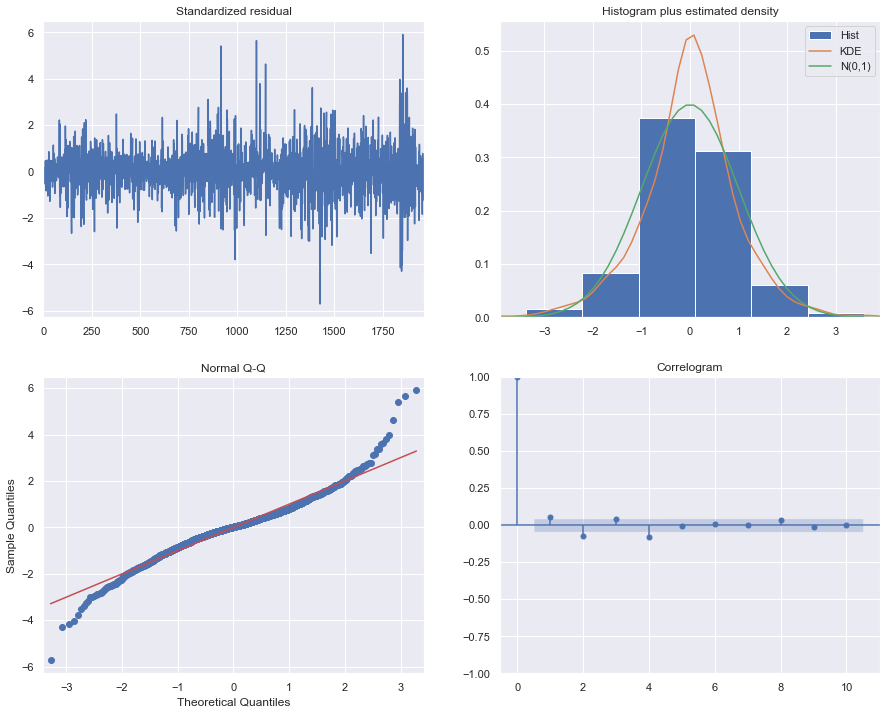

In [15]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

### Fit the SARIMAX model using the best p,d,q orders

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [17]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(4,0,0), seasonal_order=(2,1,1,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
results = model_exog.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, [1], 5)   Log Likelihood                5225.860
Date:                             Wed, 23 Nov 2022   AIC                         -10401.720
Time:                                     20:36:28   BIC                         -10262.177
Sample:                                          0   HQIC                        -10350.433
                                            - 1967                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.1317      0.022      5.892      0.000       0.088       0.176
14 DAYS MA        -0.0538      0.043     -1.256      0.209      -0.138       0.030
21 DAYS MA         0.3891      0.046      8.388      0.000       0.298       0.480
7 DAYS STD DEV    -0.0008      0.001     -1.153      0.249      -0.002       0.001
RSI 7              0.0625      0.006     10.723      0.000       0.051       0.074
RSI 14            -0.3434      0.022    -15.375      0.000      -0.387      -0.300
RSI 21             0.4667      0.019     24.364      0.000       0.429       0.504
MFI 7              0.0032      0.001      2.388      0.017       0.001       0.006
MFI 14             0.0002      0.002      0.090      0.929      -0.003       0.004
MFI 21             0.0003      0.002      0.129      0.897      -0.004       0.005
dayofweek         -0.0002      0.001     -0.354      0.724      -0.001       0.001
quarter            0.0182      0.008      2.379      0.017       0.003       0.033
month             -0.2493      0.355     -0.702      0.483      -0.945       0.447
year               0.4382      0.264      1.658      0.097      -0.080       0.956
dayofyear          0.2807      0.359      0.782      0.434      -0.423       0.984
dayofmonth        -0.0201      0.029     -0.690      0.490      -0.077       0.037
weekofyear         0.0024      0.007      0.317      0.751      -0.012       0.017
ar.L1              0.8294      0.013     62.446      0.000       0.803       0.855
ar.L2             -0.1494      0.018     -8.339      0.000      -0.185      -0.114
ar.L3              0.2350      0.018     12.998      0.000       0.200       0.270
ar.L4             -0.0821      0.016     -5.033      0.000      -0.114      -0.050
ar.S.L5           -0.4056      0.051     -7.883      0.000      -0.506      -0.305
ar.S.L10          -0.1264      0.034     -3.697      0.000      -0.193      -0.059
ma.S.L5           -0.3140      0.052     -6.031      0.000      -0.416      -0.212
sigma2             0.0003   4.83e-06     58.413      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  40.49   Jarque-Bera (JB):              6486.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [20]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [22]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [23]:
predictions

,Pred,Actual
Date,,
2020-09-10,-0.617948,-0.636735
2020-09-11,-0.526980,-0.546939
2020-09-14,-0.468031,-0.481633
2020-09-15,-0.504189,-0.530612
2020-09-16,-0.531207,-0.563265
...,...,...
2022-09-12,0.528162,0.865306
2022-09-13,0.514880,0.848980
2022-09-14,0.485309,0.816327


<AxesSubplot:xlabel='Date'>

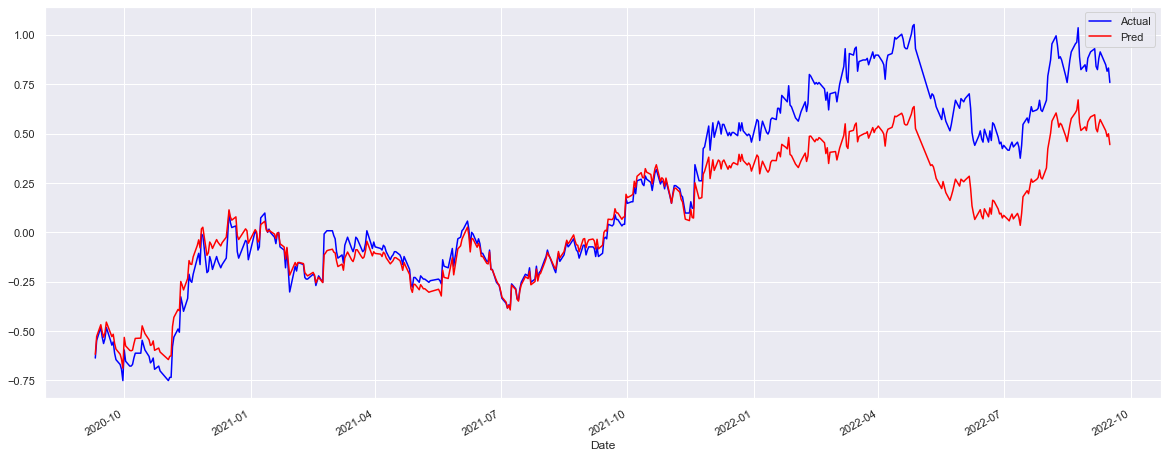

In [24]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [25]:
from joblib import load

In [26]:
close_scaler = load('../feature_engineering/tlkm_close_scaler.bin')

In [27]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [28]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

,Pred,Actual
Date,,
2020-09-10,2723.013595,2700.0
2020-09-11,2834.449909,2810.0


**Plot Error Distribution**

In [29]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

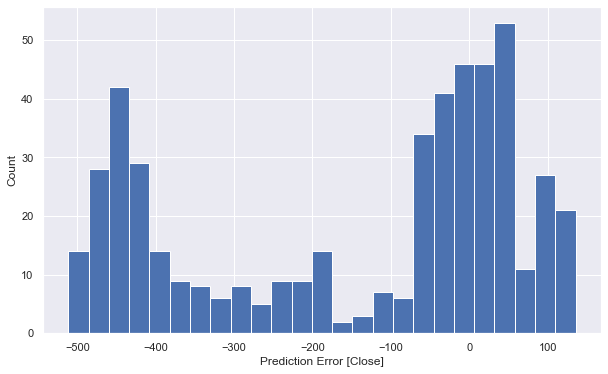

In [30]:
plt.figure(figsize=(10,6))
plotErrorHist(inversed)

**RMSE**

In [31]:
from statsmodels.tools.eval_measures import rmse

In [32]:
rmse(inversed['Pred'], inversed['Actual'])

254.373870558354

**MAPE**

In [33]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [34]:
mape(inversed['Actual'], inversed['Pred'])

4.46810975136439

**R-squared**

In [35]:
from sklearn.metrics import r2_score

In [36]:
r2_score(inversed['Actual'], inversed['Pred'])

0.7990681276317234

### Save the model

In [37]:
from joblib import dump, load
dump(results, './models/tlkm.joblib') 

['./models/tlkm.joblib']

In [38]:
loaded = load('./models/tlkm.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1967
Model:             SARIMAX(4, 0, 0)x(2, 1, [1], 5)   Log Likelihood                5225.860
Date:                             Wed, 23 Nov 2022   AIC                         -10401.720
Time:                                     20:37:22   BIC                         -10262.177
Sample:                                          0   HQIC                        -10350.433
                                            - 1967                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.1317      0.022      5.892      0.000       0.088       0.176
14 DAYS MA        -0.0538      0.043     -1.256      0.209      -0.138       0.030
21 DAYS MA         0.3891      0.046      8.388      0.000       0.298       0.480
7 DAYS STD DEV    -0.0008      0.001     -1.153      0.249      -0.002       0.001
RSI 7              0.0625      0.006     10.723      0.000       0.051       0.074
RSI 14            -0.3434      0.022    -15.375      0.000      -0.387      -0.300
RSI 21             0.4667      0.019     24.364      0.000       0.429       0.504
MFI 7              0.0032      0.001      2.388      0.017       0.001       0.006
MFI 14             0.0002      0.002      0.090      0.929      -0.003       0.004
MFI 21             0.0003      0.002      0.129      0.897      -0.004       0.005
dayofweek         -0.0002      0.001     -0.354      0.724      -0.001       0.001
quarter            0.0182      0.008      2.379      0.017       0.003       0.033
month             -0.2493      0.355     -0.702      0.483      -0.945       0.447
year               0.4382      0.264      1.658      0.097      -0.080       0.956
dayofyear          0.2807      0.359      0.782      0.434      -0.423       0.984
dayofmonth        -0.0201      0.029     -0.690      0.490      -0.077       0.037
weekofyear         0.0024      0.007      0.317      0.751      -0.012       0.017
ar.L1              0.8294      0.013     62.446      0.000       0.803       0.855
ar.L2             -0.1494      0.018     -8.339      0.000      -0.185      -0.114
ar.L3              0.2350      0.018     12.998      0.000       0.200       0.270
ar.L4             -0.0821      0.016     -5.033      0.000      -0.114      -0.050
ar.S.L5           -0.4056      0.051     -7.883      0.000      -0.506      -0.305
ar.S.L10          -0.1264      0.034     -3.697      0.000      -0.193      -0.059
ma.S.L5           -0.3140      0.052     -6.031      0.000      -0.416      -0.212
sigma2             0.0003   4.83e-06     58.413      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                  40.49   Jarque-Bera (JB):              6486.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""